输入不额外提供时间特征，仅采用去趋势的方法。

# 原始数据

In [1]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense, LSTM, Dropout, Activation, GRU
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize

timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集


x, y = get_x_y_by_sliding_window(arr, in_steps=timesteps, out_steps=1)
y = y.sum(axis=-2)  # 无论输出时间步是不是1，都要进行这项操作


x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [3]:
x_train.shape, x_test.shape

((2201, 7, 1), (672, 7, 1))

## 单层LSTM

In [4]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, validation_split=0.1, verbose=0)

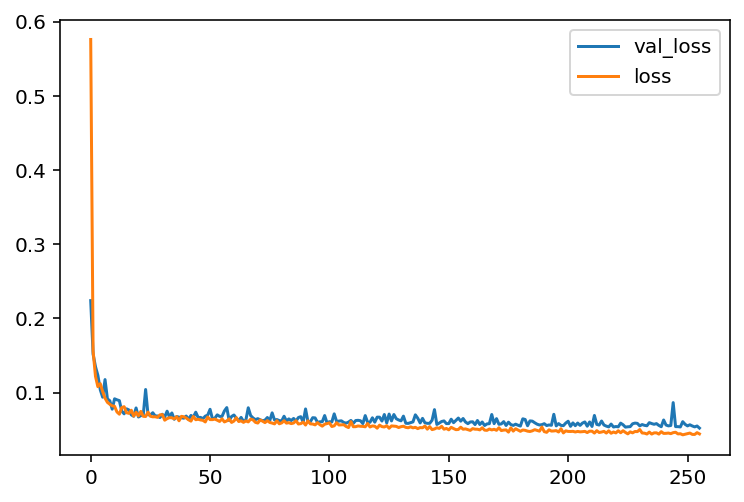

In [5]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

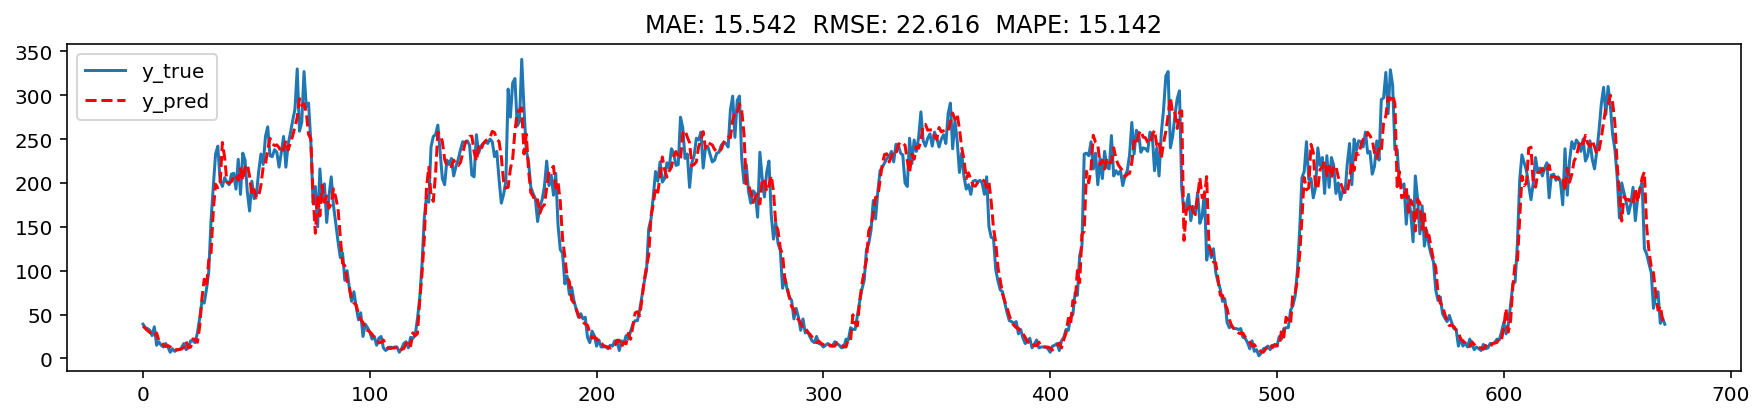

In [6]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))

## 双层LSTM

In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, validation_split=0.1, verbose=0)

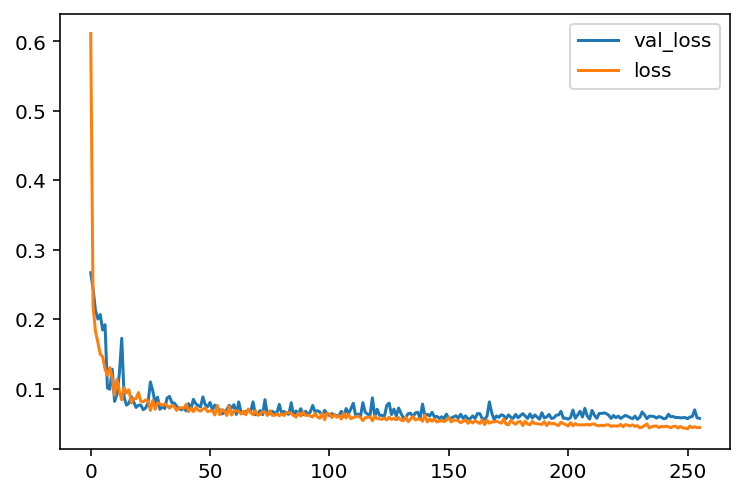

In [8]:
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()

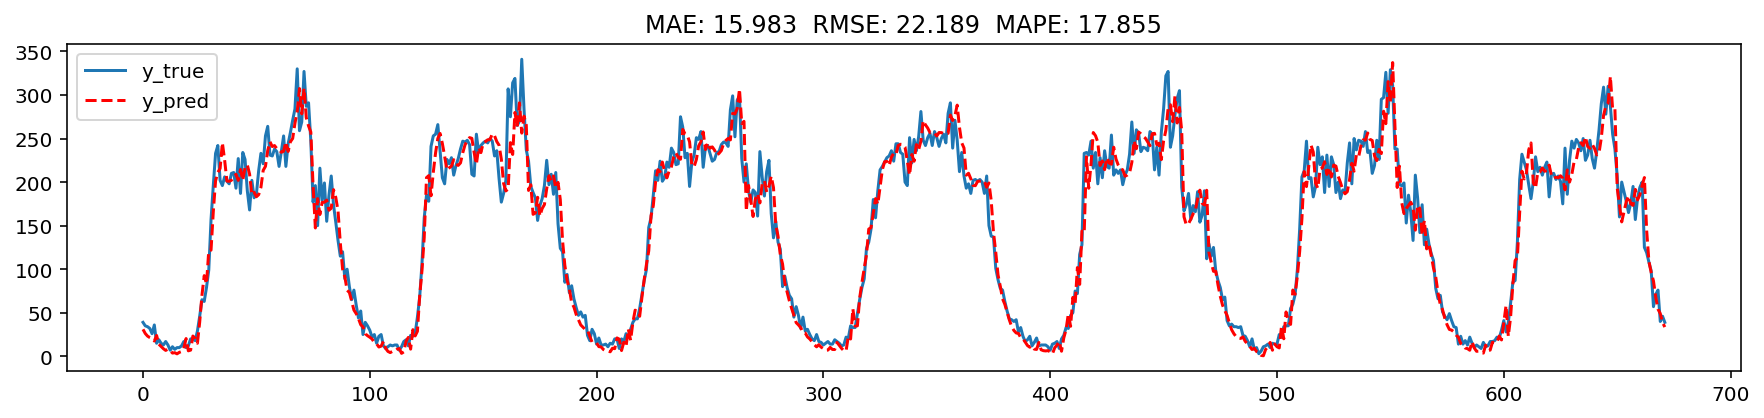

In [9]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))

# 去趋势

## 一阶差分

In [10]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()
y_train_start = ts[timesteps]
y_test_start = ts[-test_size-1]
y_test_ts = ts[-test_size-1:-1]
ts = ts.diff(1).dropna()  # 一阶差分

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize


x, y = get_x_y_by_sliding_window(arr, in_steps=timesteps, out_steps=1)
y = y.sum(axis=-2)  # 无论输出时间步是不是1，都要进行这项操作

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,1),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, verbose=0)

{'mae': 19.299089799019775,
 'rmse': 27.639723878200133,
 'mape': 20.75924666025611}

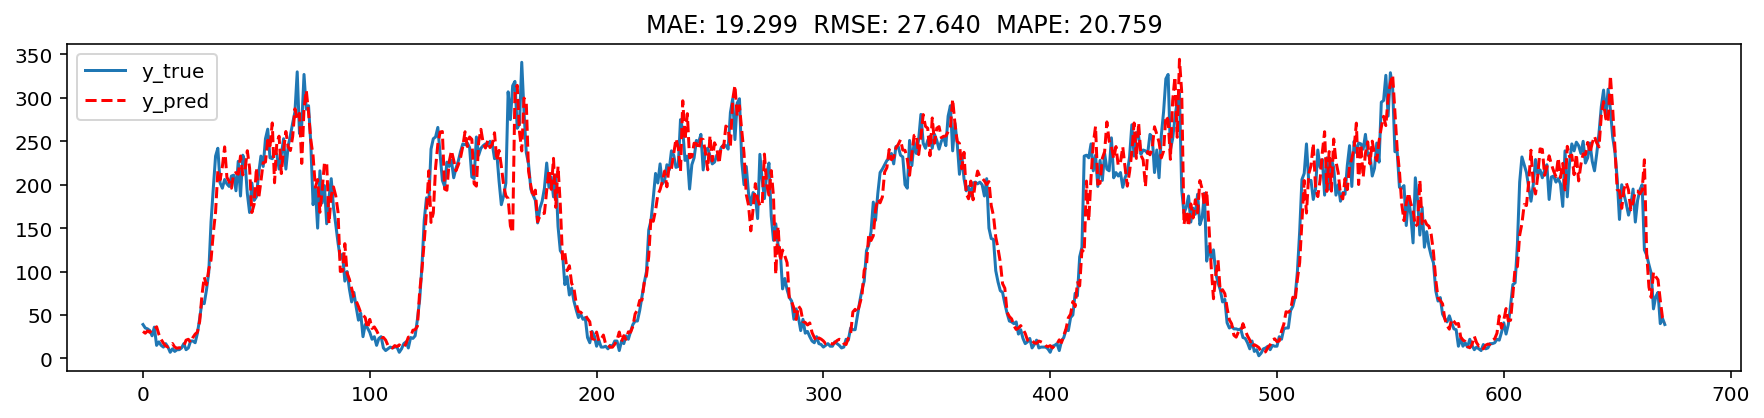

In [12]:
y_true = scaler.inverse_transform(y_test)
y_true = y_true.cumsum(axis=0) + y_test_start
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred + y_test_ts.values.reshape(-1,1)
test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))

看样子没有什么用

## 简单平均趋势（原始流量+残差->残差）

In [13]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
# trend_df = df.groupby('trend_idx').mean()
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

trend_ts = df.set_index('datetime')['trend']  # 趋势时间序列
residual_ts = ts - trend_ts  # 残差时间序列

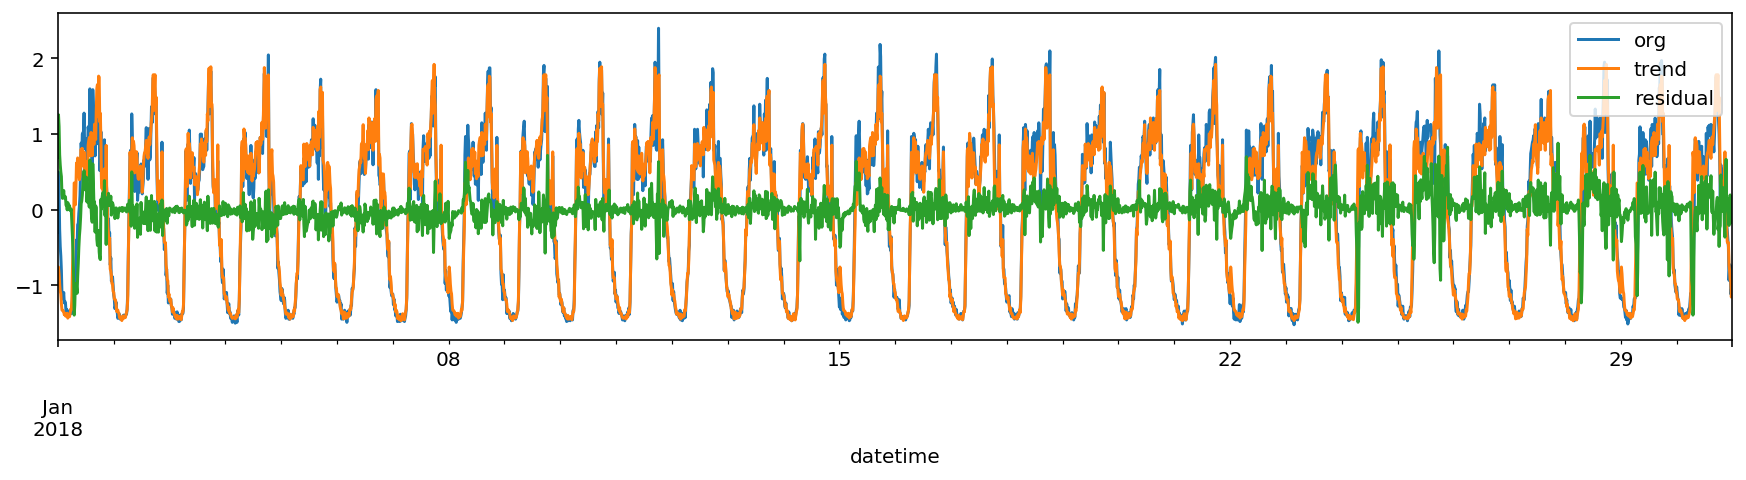

In [14]:
fig, ax = plt.subplots(figsize=(15,3))
ts.plot(ax=ax, label='org')
trend_ts.plot(ax=ax, label='trend')
residual_ts.plot(ax=ax, label='residual')
ax.legend()

In [15]:
x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

# x为输入时间步的原始时间序列与残差
# y为下一时刻的残差
x = np.concatenate([x_org, x_residual], axis=-1)
y = y_residual

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [16]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,2),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, verbose=0)

{'mae': 15.944055561508451,
 'rmse': 23.146573993462464,
 'mape': 15.505233767519092}

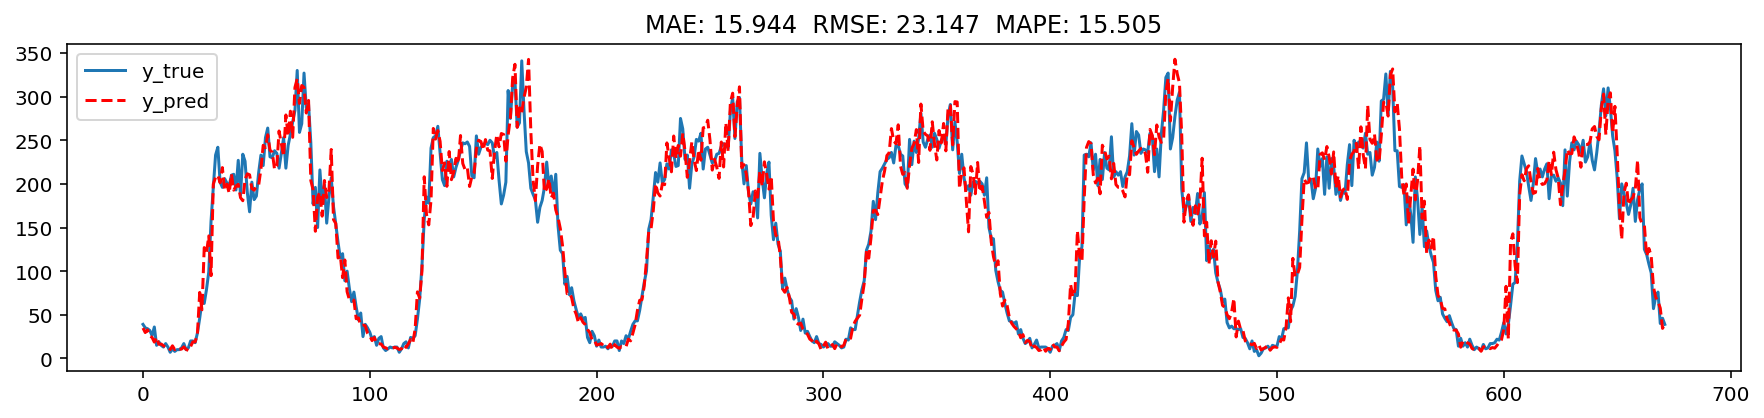

In [17]:
y_pred = model.predict(x_test)  # 残差预测值
y_pred += y_trend[-test_size:]  # 残差 + 趋势 = 时间序列
y_pred = scaler.inverse_transform(y_pred)
y_pred[y_pred<0] = 0
y_true = y_org[-test_size:]  # 时间序列真实值
y_true = scaler.inverse_transform(y_true)

test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))

## 简单平均趋势（原始流量+残差->真实流量）

In [18]:
timesteps = 7  # 时间步
test_size = 4*24*7  # 最后7天为测试集

ts = get_flow_series_by_idx(0)
ts = ts.resample('15min').sum()

scaler = StandardScaler()
arr = scaler.fit_transform(ts.values.reshape(-1,1))  # z-score normalize
ts = pd.Series(arr.reshape(-1), index=ts.index)  # 原始时间序列

df = pd.DataFrame(ts).reset_index()
df['trend_idx'] = df.datetime.apply(lambda x:str((x.weekday(),x.hour, x.minute)))
trend_df = df.iloc[0:-test_size].groupby('trend_idx').mean()  # 仅使用训练集的趋势
df['trend'] = df.trend_idx.apply(lambda x: trend_df.loc[x])

trend_ts = df.set_index('datetime')['trend']
residual_ts = ts - trend_ts  # 残差时间序列

x_trend, y_trend = get_x_y_by_sliding_window(trend_ts, in_steps=timesteps, out_steps=1)
y_trend = y_trend.sum(axis=-2)

x_residual, y_residual = get_x_y_by_sliding_window(residual_ts, in_steps=timesteps, out_steps=1)
y_residual = y_residual.sum(axis=-2)

x_org, y_org = get_x_y_by_sliding_window(ts, in_steps=timesteps, out_steps=1)
y_org = y_org.sum(axis=-2)

# x为输入时间步的流量与残差
# y为下一时刻的流量
x = np.concatenate([x_org, x_residual], axis=-1)
y = y_org

x_train, y_train, x_test, y_test = split_train_test(x, y, test_size=test_size)

In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps,2),return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(x=x_train, y=y_train, epochs=256, batch_size=256, verbose=0)

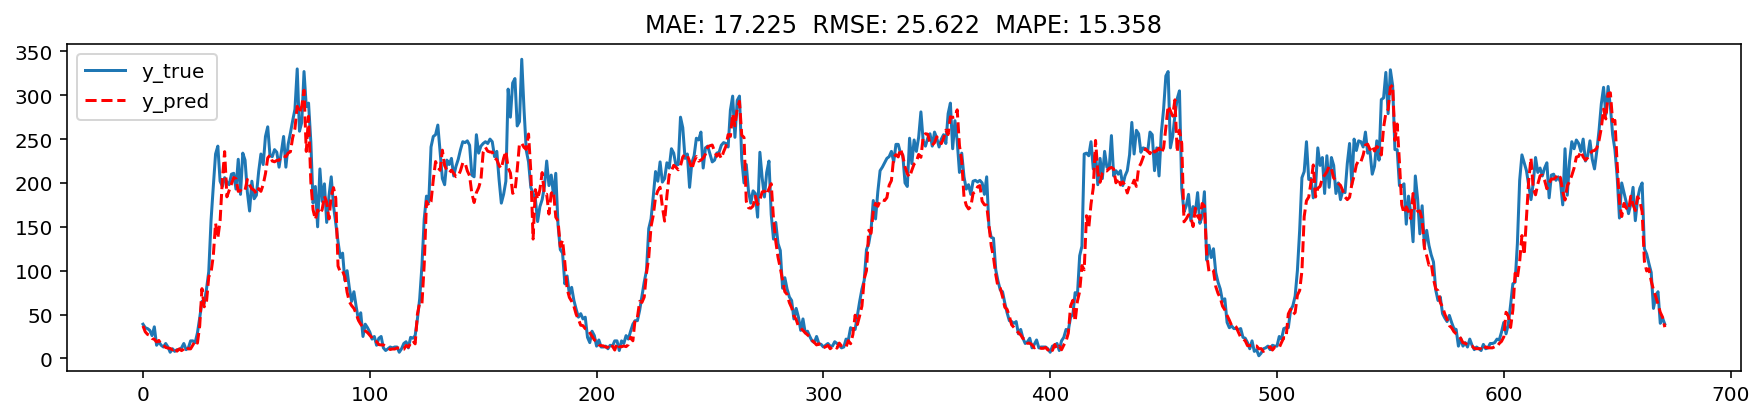

In [20]:
test_model(model, x_test, y_test, scaler=scaler, plot_with_figsize=(15,3))